# Model Building Process of Code:

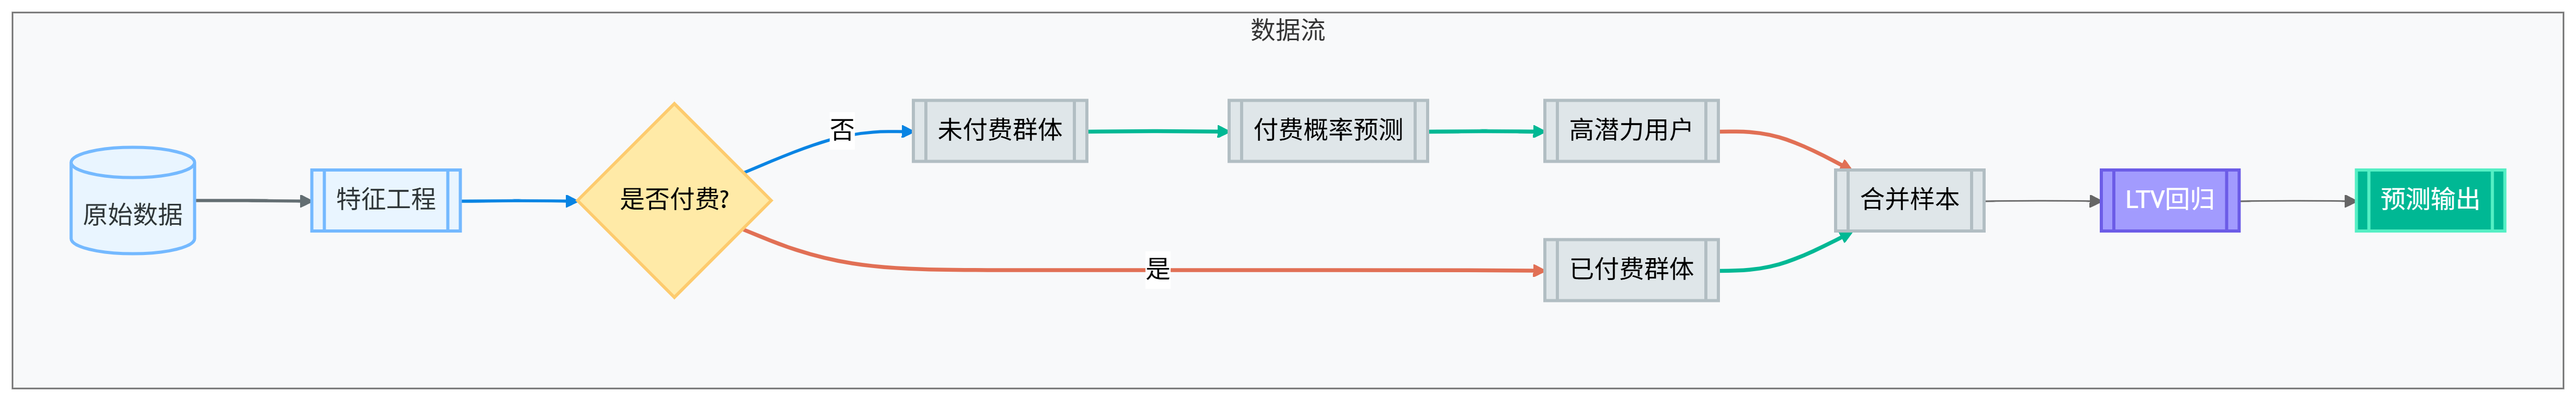

In [1]:
from IPython.display import Image
Image("/kaggle/input/process-image/deepseek_mermaid_20250613_79aa76.png", width=500)  # 调整宽度

# 导入后续需要的包

In [2]:
# 导入必要的包

import warnings
warnings.simplefilter('ignore')

import os
import gc

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from tqdm.auto import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score, classification_report, roc_auc_score

import lightgbm as lgb
from lightgbm import LGBMClassifier

# 需要输入的参数

In [3]:
# 历史参考数据路径
path_ref1 = "/kaggle/input/vm3-202407-part1/VM3-202407-part1.csv"
path_ref2 = "/kaggle/input/vm3-202407-part2/VM3-202407-part2.csv"
path_pre1 = "/kaggle/input/vm3-202501-part1/VM3-202501-part1.csv"
path_pre2 = "/kaggle/input/vm3-202501-part2/VM3-202501-part2.csv"
# 需要预测的模型周期
# 预测周期
days_list = [7, 30, 60, 90, 120, 240, 300] 

# 待预测期群的总花费
cost = 3065691.6 


# 权重分位数
percentiles = [0.5, 0.8, 0.9, 0.95, 0.99, 1.0]
base_weights = [1, 5, 10, 50, 500, 1000]

# 头部玩家个数绝对值-训练集
top_num = 200


# 固定参数-特征参数

In [4]:
# 选择活跃特征-没有付费行为
# 或者直接drop掉payer_tag里的特征 if exists
# 数值型特征

# 特征周期
active_day3_features = ['first_duration', 'd0_duration', 'active_in3days', 'avg_dur3days']
active_day7_features = ['active_in7days', 'avg_dur7days']
active_day30_features = ['active_in30days', 'avg_dur30days']
active_day60_features = ['active_in2month', 'avg_dur2month']
active_day90_features = ['active_in3month', 'avg_dur3month']
active_day120_features = ['active_in4month', 'avg_dur4month']
active_day240_features = ['active_in5months', 'avg_dur5months']
# 预测周期
day7_active_features = active_day3_features
day30_active_features = active_day3_features + active_day7_features
day60_active_features = active_day3_features + active_day7_features + active_day30_features
day90_active_features = active_day3_features + active_day7_features + active_day30_features + active_day60_features
day120_active_features = active_day3_features + active_day7_features + active_day30_features + active_day60_features + active_day90_features
day240_active_features = active_day3_features + active_day7_features + active_day30_features + active_day60_features + active_day90_features + active_day120_features
day300_active_features = active_day3_features + active_day7_features + active_day30_features + active_day60_features + active_day90_features + active_day120_features + active_day240_features



# 特征周期
day3_features = ['first_duration', 'd0_duration', 'active_in3days', 'avg_dur3days', 'd0_usd', 'pay_in3days', 'avg_usd3days']
day7_features = ['active_in7days', 'avg_dur7days', 'pay_in7days', 'avg_usd7days']
day30_features = ['active_in30days', 'avg_dur30days', 'pay_in30days', 'avg_usd30days']
day60_features = ['active_in2month', 'avg_dur2month', 'pay_in2month', 'avg_usd2month']
day90_features = ['active_in3month', 'avg_dur3month', 'pay_in3month', 'avg_usd3month']
day120_features = ['active_in4month', 'avg_dur4month', 'pay_in4month', 'avg_usd4month']
day240_features = ['active_in5months', 'avg_dur5months', 'pay_in5months', 'avg_usd5months']
# 预测周期
day7_num_features = day3_features
day30_num_features = day3_features + day7_features
day60_num_features = day3_features + day7_features + day30_features
day90_num_features = day3_features + day7_features + day30_features + day60_features
day120_num_features = day3_features + day7_features + day30_features + day60_features + day90_features
day240_num_features = day3_features + day7_features + day30_features + day60_features + day90_features + day120_features
day300_num_features = day3_features + day7_features + day30_features + day60_features + day90_features + day120_features + day240_features

num_features = day300_num_features

# 类别型特征
cat_features = ['countrytype', 'os', 'source', 'install_device', 'social_type']

# 标签与主键
target_col = ['LTV_7day', 'LTV_30day', 'LTV_60day', 'LTV_90day', 'LTV_120day', 'LTV_240day', 'LTV_300day']
id_col = 'user_id'

# 预测周期参数-ALL

In [5]:
days = [7, 30, 60, 90, 120, 240, 300]
day_valid = [7, 30, 60, 90, 120]
num_features_map = {
    7: day7_num_features,
    30: day30_num_features,
    60: day60_num_features,
    90: day90_num_features,
    120: day120_num_features,
    240: day240_num_features,
    300: day300_num_features
}

# 周期内是否付费判断特征
payer_tag = ['d0_usd', 'pay_in3days', 'pay_in7days', 'pay_in30days', 'pay_in2month', 'pay_in3month', 'pay_in4month', 'pay_in5months', 
             'avg_usd3days', 'avg_usd7days', 'avg_usd30days','avg_usd2month', 'avg_usd3month', 'avg_usd4month', 'avg_usd5months']

# 读取需要的历史参考数据-训练数据

In [6]:
# 读取数据集

# 加载数据
df1 = pd.read_csv(path_ref1)
df2 = pd.read_csv(path_ref2)# TODO: 替换为你的历史参考数据集
# 重新建立索引
df =  pd.concat([df1, df2], axis=0, ignore_index=True)
print(df.shape)
df.head()


(1118754, 47)


,user_id,regdate,first_pay_day,source,countrytype,os,install_device,social_type,is_facebook_messenger_installed,first_duration,d0_duration,active_in3days,active_in7days,active_in30days,active_in2month,active_in3month,active_in4month,active_in5months,avg_dur3days,avg_dur7days,avg_dur30days,avg_dur2month,avg_dur3month,avg_dur4month,avg_dur5months,d0_usd,pay_in3days,pay_in7days,pay_in30days,pay_in2month,pay_in3month,pay_in4month,pay_in5months,avg_usd3days,avg_usd7days,avg_usd30days,avg_usd2month,avg_usd3month,avg_usd4month,avg_usd5months,LTV_7day,LTV_30day,LTV_60day,LTV_90day,LTV_120day,LTV_240day,LTV_300day
0,693191301,2024-07-07,NaN,Other_source,美国,iOS,"iPhone16,2",Guest,True,NaN,NaN,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,698348661,2024-07-14,NaN,Organic,欧盟加澳,Android,SM-A137F,Express,False,NaN,NaN,1,1,1,0,0,0,0,81.38,81.38,81.38,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,696643600,2024-07-12,NaN,Organic,其他国家,Android,TECNO BB4k,Express,False,30.89,46.95,1,1,1,0,0,0,0,46.95,46.95,46.95,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,690543180,2024-07-04,3.0,Other_source,日本,Android,SO-01M,Express,False,18.53,181.87,4,7,29,31,29,26,95,90.96,66.46,64.34,104.61,80.09,37.42,38.53,NaN,1,2,6,4,5,2,36,1.99,2.49,4.78,17.93,10.92,26.15,12.12,4.98,28.66,100.36,152.75,205.04,641.31,1103.5
4,645921123,2024-07-07,NaN,FB_AEO,其他国家,Android,2201117SY,Express,True,NaN,NaN,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# 用 0 填充缺失值
df.fillna(0, inplace=True)

# 基础数据结构
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118754 entries, 0 to 1118753
Data columns (total 47 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   user_id                          1118754 non-null  int64  
 1   regdate                          1118754 non-null  object 
 2   first_pay_day                    1118754 non-null  float64
 3   source                           1118754 non-null  object 
 4   countrytype                      1118754 non-null  object 
 5   os                               1118754 non-null  object 
 6   install_device                   1118754 non-null  object 
 7   social_type                      1118754 non-null  object 
 8   is_facebook_messenger_installed  1118754 non-null  object 
 9   first_duration                   1118754 non-null  float64
 10  d0_duration                      1118754 non-null  float64
 11  active_in3days                   1118754 non-null 

,user_id,first_pay_day,first_duration,d0_duration,active_in3days,active_in7days,active_in30days,active_in2month,active_in3month,active_in4month,active_in5months,avg_dur3days,avg_dur7days,avg_dur30days,avg_dur2month,avg_dur3month,avg_dur4month,avg_dur5months,d0_usd,pay_in3days,pay_in7days,pay_in30days,pay_in2month,pay_in3month,pay_in4month,pay_in5months,avg_usd3days,avg_usd7days,avg_usd30days,avg_usd2month,avg_usd3month,avg_usd4month,avg_usd5months,LTV_7day,LTV_30day,LTV_60day,LTV_90day,LTV_120day,LTV_240day,LTV_300day
count,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06,1.118754e+06
mean,6.708060e+08,1.127367e+00,1.068518e+01,2.789950e+01,1.199270e+00,1.793056e+00,3.906200e+00,1.832393e+00,1.325976e+00,1.042124e+00,2.721502e+00,3.155286e+01,2.987050e+01,2.766891e+01,6.526327e+00,4.207222e+00,3.131565e+00,3.363328e+00,4.664313e-02,2.194227e-02,3.822914e-02,9.829864e-02,5.029881e-02,3.555205e-02,2.771566e-02,7.677917e-02,1.381579e-01,1.726956e-01,2.263510e-01,1.049077e-01,7.404180e-02,5.710659e-02,6.266846e-02,4.330080e-01,1.143611e+00,1.719386e+00,2.101724e+00,2.383278e+00,3.119194e+00,3.384277e+00
std,2.682185e+07,1.345500e+01,2.311003e+01,5.782698e+01,1.297694e+00,2.269596e+00,7.082314e+00,5.985955e+00,5.198112e+00,4.621019e+00,1.393849e+01,5.066338e+01,4.610830e+01,4.144271e+01,2.222956e+01,1.709832e+01,1.437707e+01,1.473018e+01,2.055858e+00,2.000564e-01,3.291644e-01,8.881580e-01,6.758719e-01,5.552255e-01,4.874129e-01,1.455545e+00,2.352923e+00,2.426871e+00,2.517904e+00,1.546003e+00,1.295427e+00,1.089087e+00,1.021736e+00,7.954040e+00,2.012109e+01,3.070883e+01,3.766807e+01,4.269895e+01,5.597321e+01,6.138133e+01
min,1.605024e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.500262e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.591417e+08,0.000000e+00,1.060000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.320000e+00,8.150000e+00,9.720000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,6.968262e+08,0.000000e+00,1.262000e+01,3.002000e+01,2.000000e+00,2.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.541000e+01,4.404000e+01,4.091000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,

# 特征的选择和处理

去掉特征：首次付费时间first_pay_day&注册日期regdate

In [8]:

# 定义输入输出
X = df[num_features + cat_features]
y = df[target_col]
user_ids = df[id_col]

# 将object类型修改为category
for col in cat_features:
        X[col] = X[col].astype('category')

In [9]:
# 划分测试集、训练集和验证集
from sklearn.model_selection import train_test_split

# 第一步：训练集 & 测试集划分

# 将历史数据划分为两部分:训练集和验证集
X_train, X_valid, y_train, y_valid, id_train, id_valid = train_test_split(
    X, y, user_ids, test_size=0.3, random_state=42)

# 第二步：从训练集中划分验证集（valid）
# X_train, X_valid, y_train, y_valid, id_train, id_valid = train_test_split(
#     X_train_full, y_train_full, id_train_full, test_size=0.2, random_state=42)

In [ ]:
# print(type(X_train), type(X_valid), type(y_train), type(y_valid), type(id_train), type(id_valid))

# # X和y的索引对应一致
# print(X_train.head(), y_train.head(), id_train.head())

# 根据预测周期的不同，划分不同的特征集合，避免未来数据泄露

In [10]:
# 划分不同的特征集合-X_train X_test
# 利用相同的历史数据构建不同的预测模型

# X_train_day7, X_valid_day7, y_train_day7, y_valid_day7 = X_train[day7_num_features+cat_features], X_valid[day7_num_features+cat_features], y_train[0], y_valid[0]

for i, day in enumerate(days, start=0):
    features = num_features_map[day] + cat_features
    globals()[f"X_train_day{day}"] = X_train[features]
    globals()[f"X_valid_day{day}"] = X_valid[features]
    globals()[f"y_train_day{day}"] = y_train.iloc[:, i]
    globals()[f"y_valid_day{day}"] = y_valid.iloc[:, i]

    # print(f"===== Day {day} =====")
    # print(f"X_train_day{day}.head():")
    # print(globals()[f"X_train_day{day}"].head(), "\n")
    # print(f"X_valid_day{day}.head():")
    # print(globals()[f"X_valid_day{day}"].head(), "\n")
    # print(f"y_train_day{day}.head():")
    # print(globals()[f"y_train_day{day}"].head(), "\n")
    # print(f"y_valid_day{day}.head():")
    # print(globals()[f"y_valid_day{day}"].head(), "\n")



# 将玩家进行分类
* 特征周期内有过付费行为--payer--预测后续付费金额
* 特征周期内暂无付费行为，后续有可能破冰转化--需要预测是否转化

In [11]:
# 数据集的划分筛选



def paid_split(X, y, payer_tag):
    existing_payer_tag = [col for col in payer_tag if col in X.columns]
    if not existing_payer_tag:
        raise ValueError("❌ X中不包含任何payer_tag列，无法识别未付费用户。")
    # 特征周期内未付费样本（集合1）
    mask_unpaid = (X[existing_payer_tag].sum(axis=1) == 0)
    X1 = X[mask_unpaid]
    y1 = y[mask_unpaid] 

    # 特征周期内已付费样本（集合2）
    mask_paid = ~mask_unpaid
    X2 = X[mask_paid]
    y2 = y[mask_paid]

    return X1, X2, y1, y2

# 划分数据
# 不做筛选--筛选在后续封装函数内部进行
# 建立deep copy--保证原始数据集的稳定
# 索引不会重置--保证后续通过索引连接
for day in days:
    print(f"\n--- Day {day} ---")
    
    # 训练集
    X1, X2, y1, y2 = paid_split(eval(f"X_train_day{day}"), eval(f"y_train_day{day}"), payer_tag)
    globals()[f"X_train_day{day}_1"] = X1
    globals()[f"y_train_day{day}_1"] = y1
    globals()[f"X_train_day{day}_2"] = X2
    globals()[f"y_train_day{day}_2"] = y2


    # check
    # print(f"\n[Train Group 1 - Non-Paid]")
    # print(f"Samples: {X1.shape[0]}, Positive Rate: {(y1 > 0).mean():.2%}")
    # print(X1.head())
    # print(y1.head())

    # print(f"\n[Train Group 2 - Paid]")
    # print(f"Samples: {X2.shape[0]}, Positive Rate: {(y2 > 0).mean():.2%}")
    # print(X2.head())
    # print(y2.head())

    # 验证集
    X1, X2, y1, y2 = paid_split(eval(f"X_valid_day{day}"), eval(f"y_valid_day{day}"), payer_tag)
    globals()[f"X_valid_day{day}_1"] = X1
    globals()[f"y_valid_day{day}_1"] = y1
    globals()[f"X_valid_day{day}_2"] = X2
    globals()[f"y_valid_day{day}_2"] = y2


    # check
    # print(f"\n[Valid Group 1 - Non-Paid]")
    # print(f"Samples: {X1.shape[0]}, Positive Rate: {(y1 > 0).mean():.2%}")
    # print(X1.head())
    # print(y1.head())

    # print(f"\n[Valid Group 2 - Paid]")
    # print(f"Samples: {X2.shape[0]}, Positive Rate: {(y2 > 0).mean():.2%}")
    # print(X2.head())
    # print(y2.head())
    



--- Day 7 ---

--- Day 30 ---

--- Day 60 ---

--- Day 90 ---

--- Day 120 ---

--- Day 240 ---

--- Day 300 ---


# 构建分类模型--玩家后续是否破冰付费

In [12]:
params_clf = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'scale_pos_weight': 90,
    'num_leaves': 31,
    'verbose': -1
}

In [13]:
# 构建分类模型-预测玩家付费还是不付费
# 本质为预测先前没有付费的玩家是否会在后续预测周期内进行破冰付费
# 由于付费的人数极少，增加正样本的权重
def train_clf(X_train, X_valid, y_train, y_valid, params_clf):
    '''
        数据集：特征周期内暂未付费人群
        二分类：预测后续周期内是否破冰付费，0/1
        return 模型和模型性能评估
    '''
    existing_payer_tag = [col for col in payer_tag if col in X_train.columns]
    if not existing_payer_tag:
        raise ValueError("❌ X中不包含任何payer_tag列，无法识别未付费用户。")
        
    # 特征处理
    # 只保留活跃维度特征
    X_tr = X_train.drop(columns=existing_payer_tag)
    X_val = X_valid.drop(columns=existing_payer_tag)
    y_tr = (y_train > 0).astype(int)
    y_val = (y_valid > 0).astype(int)
    train_set = lgb.Dataset(X_tr, label=y_tr)
    val_set = lgb.Dataset(X_val, label=y_val)
    
    clf = lgb.train(
        params_clf,
        train_set,
        valid_sets=[train_set, val_set],
        callbacks=[lgb.early_stopping(stopping_rounds=20)],
    )
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = list(X_tr.columns)
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    fold_importance_df = fold_importance_df.sort_values(by='importance', ascending=False)
    # fold_importance_df.to_csv(f"importance_df_clf.csv", index=None) 

    # print("分类预测输入特征矩阵范例：", X_val)
    y_pred_proba = clf.predict(X_val, num_iteration=clf.best_iteration)
    # 以概率划定 二分类问题
    y_pred = (y_pred_proba > 0.5).astype(int)

    result = {
    "classification_report": classification_report(y_val, y_pred),
    "AUC": roc_auc_score(y_val, y_pred_proba)
    }

    return clf, result, fold_importance_df

# 构建回归模型--玩家后续周期具体的付费金额

In [14]:
# 构建回归模型

params_reg = {
    'objective': 'regression',             # 目标函数，回归任务（如预测连续值）
    'metric': {'rmse'},                    # 评估指标，使用 RMSE（均方根误差）
    'boosting_type' : 'gbdt',              # 提升方法，GBDT = 梯度提升树
    'learning_rate': 0.05,                 # 学习率，每次迭代权重的缩放因子，较小值更稳定但需更多迭代
    'max_depth' : 12,                      # 树的最大深度，限制模型复杂度，防止过拟合
    'num_leaves' : 2 ** 12,                 # 每棵树最多的叶子数（影响模型表达力，通常 <= 2^max_depth）
    'feature_fraction' : 0.70,             # 每棵树随机选择 70% 特征进行训练（特征采样，防止过拟合）
    'subsample' : 0.75,                    # 每次迭代随机选取 75% 数据训练（样本采样，用于 bagging）
    'seed' : 114,                          # 随机数种子，确保结果可复现
    'num_iterations' : 10000,               # 最多训练轮数（最多构造 3000 棵树）
    'nthread' : -1,                        # 使用所有可用 CPU 核心（自动设置线程数）
    'verbose' : -1                         # 输出等级，-1 表示完全不输出训练日志
}

def r2_eval(preds, train_data):
    labels = train_data.get_label()
    return 'r2', r2_score(labels, preds), True



# **划分付费结构**

In [15]:
# 封装--模型的训练和预测
def train_reg(
    X_train, X_valid, y_train, y_valid, params, num_features, cat_features, 
    value_weighting=True):
    
    '''
    训练函数
    - value_weighting: 是否对高价值用户加权，如果需要加权重，将参数置为True
    - quantile: 高价值分位阈值（如 top 1%）需要根据不同项目进行调整
    - weight_multiplier: 高价值用户的权重倍数
    '''
    
    # log1p 变换目标
    y_train_log = np.log1p(y_train)
    y_valid_log= np.log1p(y_valid)

    # 默认权重为1
    train_weights = np.ones(len(y_train))

    if value_weighting:
       
        bins = sorted(set([y_train.quantile(p) for p in percentiles]))

        if len(bins) < 2:
            raise ValueError("有效的分位 bin 不足，可能是 y_train 全为 0 或重复")
    
        labels = list(range(len(bins) - 1))
        quantile_bins = pd.cut(y_train, bins=bins, labels=labels, include_lowest=True)
    
        # 生成默认权重为1
        train_weights = np.ones(len(y_train))
        # 只对分桶成功的样本加权
        mask_valid = ~quantile_bins.isna()
        quantile_ids = quantile_bins[mask_valid].astype(int)
        train_weights[mask_valid] = [base_weights[i] for i in quantile_ids]
        # 手动再将最大值（比如 top10 个）设为 1000
        top_k_idx = np.argsort(y_train.values)[-top_num:]  # top 10 大的样本
        train_weights[top_k_idx] = base_weights[-1]  # 强制赋值为 1000


    print(pd.value_counts(train_weights, sort=False))

        # high_value_threshold = np.quantile(y_train, quantile)
        # high_value_mask = y_train >= high_value_threshold
        # train_weights[high_value_mask] = weight_multiplier
        # print(f"⚖️ 高价值用户加权：{high_value_mask.sum()} 个样本权重设置为 {weight_multiplier}")

    features = num_features + cat_features
    
    # 封装数据集
    trn_data = lgb.Dataset(X_train, label=y_train_log, categorical_feature=cat_features, weight=train_weights)
    val_data = lgb.Dataset(X_valid, label=y_valid_log, categorical_feature=cat_features, reference=trn_data)
    reg = lgb.train(params_reg,
                    trn_data,
                    valid_sets=[trn_data, val_data],
                    feval = r2_eval,
                    callbacks=[
                        lgb.early_stopping(stopping_rounds=50),
                        lgb.log_evaluation(period=500)])  # 相当于 verbose_eval=100)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = reg.feature_importance()
    fold_importance_df["importance_gain"] = reg.feature_importance(importance_type='gain')
    fold_importance_df = fold_importance_df.sort_values(by='importance', ascending=False)
    # fold_importance_df.to_csv(f"importance_df_reg.csv", index=None) 

    # print("回归预测输入特征矩阵范例：", X_valid)
    # 预测对数log
    y_preds_log = reg.predict(X_valid, num_iteration=reg.best_iteration)
    # 对数log还原+负值修正
    y_preds = pd.Series(np.expm1(y_preds_log)).clip(lower=0).values

    # 模型评估参数--均方误差和R2
    result = {
        "MSLE": mean_squared_log_error(y_valid, y_preds),
        "R2": r2_score(y_valid, y_preds)
    }
    
    return reg, result, fold_importance_df



In [16]:
# 构建不同时间跨度的LTV预测模型
# 分类模型--判断有后续付费的可能--回归模型--预测具体数值

# days_list = [30, 120]

# 训练过程封装
# 固定预测周期
# 兼容验证集为空的情况
def train_process(X_train_1, X_valid_1, X_train_2, X_valid_2, y_train_1, y_valid_1, y_train_2, y_valid_2, params_clf, params_reg, num_features, cat_features):
    '''
    二分类模型确定后续付费情况
    回归模型预测后续LTV
    _1: 特征周期内未付费玩家数据集
    _2: 特征周期内已付费玩家（payer）数据集
    '''
    # 验证集为空判断
    # 目的是只训练不验证
    only_train = any(df is None for df in [X_valid_1, X_valid_2, y_valid_1, y_valid_2])
    if only_train:
        # 构造空但结构一致的DataFrame
        X_valid_1 = pd.DataFrame(columns=X_train_1.columns)
        X_valid_2 = pd.DataFrame(columns=X_train_2.columns)
        y_valid_1 = pd.Series(dtype='float64')
        y_valid_2 = pd.Series(dtype='float64')
        print("只训练，不验证")
        
    # 特征周期内暂未付费玩家的数据集进行分类模型训练
    clf_valid, result_valid_clf, importance_clf = train_clf(X_train_1, X_valid_1, y_train_1, y_valid_1, params_clf)
    
    # 将数据集合1进行预测
    existing_payer_tag = [col for col in payer_tag if col in X_train_1.columns]
    if not existing_payer_tag:
        raise ValueError("❌ X中不包含任何payer_tag列，无法识别未付费用户。")
    temp = clf_valid.predict(X_train_1.drop(columns=existing_payer_tag))
    
    # 建立deep copy
    X_train_1_copy = X_train_1.copy()
    X_train_1_copy['pay_class_pred'] = (temp > 0.5).astype(int)
    
    # eval(f"X_train_day{day}_1")['pay_class_pred'] = (temp > 0.5).astype(int)
    # print(eval(f"X_train_day{day}_1").drop(columns=existing_payer_tag).head())
    
    # 建立deep copy
    X_valid_1_copy = X_valid_1.copy()
    if not X_valid_1.empty:
        temp= clf_valid.predict(X_valid_1.drop(columns=existing_payer_tag))
        X_valid_1_copy['pay_class_pred'] = (temp > 0.5).astype(int)
    else:
        X_valid_1_copy['pay_class_pred'] = pd.Series(dtype='int')
    # eval(f"X_valid_day{day}_1")['pay_class_pred'] = (temp > 0.5).astype(int)

    # 筛选数据
    mask_payfu_1 = (X_train_1_copy['pay_class_pred']==1)
    mask_payfu_2 = (X_valid_1_copy['pay_class_pred']==1)

    # 合并数据
    X_combined_train = pd.concat(
        [X_train_1_copy[mask_payfu_1].drop(columns='pay_class_pred'), X_train_2], axis = 0)
    y_combined_train = pd.concat(
        [y_train_1[mask_payfu_1], y_train_2], axis = 0)

    X_combined_valid = pd.concat(
        [X_valid_1_copy[mask_payfu_2].drop(columns='pay_class_pred'), X_valid_2], axis = 0)
    y_combined_valid = pd.concat(
        [y_valid_1[mask_payfu_2], y_valid_2], axis = 0)

    reg_valid, result_valid_reg, importance_reg = train_reg(X_combined_train, X_combined_valid, y_combined_train, y_combined_valid, params_reg, num_features, cat_features)
    model_result = {
        'model_clf': clf_valid,
        'result_clf': result_valid_clf,
        'im_clf': importance_clf,
        'model_reg': reg_valid,
        'result_reg': result_valid_reg,
        'im_reg': importance_reg
    }

    # 如果只训练模型不验证 
    # 只返回模型
    if only_train:
        model_result.update({
            'model_clf': clf_valid,
            'model_reg': reg_valid,
        })
    return model_result
    
    


In [17]:
model_results = {}
for day in days_list:
    model_results[day] = train_process(
        eval(f"X_train_day{day}_1"), eval(f"X_valid_day{day}_1"), eval(f"X_train_day{day}_2"), eval(f"X_valid_day{day}_2"),
        eval(f"y_train_day{day}_1"), eval(f"y_valid_day{day}_1"), eval(f"y_train_day{day}_2"), eval(f"y_valid_day{day}_2"),
        params_clf, params_reg, eval(f"day{day}_num_features"), cat_features)
    

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.179068	valid_1's binary_logloss: 0.183666
1.0       83242
5.0        4616
10.0       3701
1000.0      200
50.0        724
Name: count, dtype: int64
Training until validation scores don't improve for 50 rounds
[500]	training's rmse: 0.236094	training's r2: 0.891441	valid_1's rmse: 0.47894	valid_1's r2: 0.747899
[1000]	training's rmse: 0.170563	training's r2: 0.929085	valid_1's rmse: 0.475063	valid_1's r2: 0.751963
[1500]	training's rmse: 0.136639	training's r2: 0.947967	valid_1's rmse: 0.472989	valid_1's r2: 0.754125
[2000]	training's rmse: 0.116039	training's r2: 0.959137	valid_1's rmse: 0.471984	valid_1's r2: 0.755169
Early stopping, best iteration is:
[2189]	training's rmse: 0.109866	training's r2: 0.962305	valid_1's rmse: 0.471689	valid_1's r2: 0.755475
Training until validation scores don't improve for 20 rounds
Early stopping, best iterati

In [18]:
for day, results in model_results.items():
    print(f"Day {day} 模型和结果：")
    
    print("分类模型（model_clf）：", results['model_clf'])
    
    print("分类结果（result_clf）：")
    if hasattr(results['result_clf'], 'head'):
        print(results['result_clf'].head())
    else:
        print(results['result_clf'])
    
    print("回归模型（model_reg）：", results['model_reg'])
    
    print("回归结果（result_reg）：")
    if hasattr(results['result_reg'], 'head'):
        print(results['result_reg'].head())
    else:
        print(results['result_reg'])
    
    print("-" * 60)

    results['im_clf'].to_csv(f"importance_df_clf_DAY{day}.csv", index=None) 
    results['im_reg'].to_csv(f"importance_df_reg_DAY{day}.csv", index=None) 

Day 7 模型和结果：
分类模型（model_clf）： <lightgbm.basic.Booster object at 0x79e873d145d0>
分类结果（result_clf）：
{'classification_report': '              precision    recall  f1-score   support\n\n           0       1.00      0.90      0.95    328965\n           1       0.03      0.62      0.06      1683\n\n    accuracy                           0.90    330648\n   macro avg       0.51      0.76      0.50    330648\nweighted avg       0.99      0.90      0.94    330648\n', 'AUC': 0.8768385783030644}
回归模型（model_reg）： <lightgbm.basic.Booster object at 0x79e87111a010>
回归结果（result_reg）：
{'MSLE': 0.21017372411724827, 'R2': 0.6781918369924135}
------------------------------------------------------------
Day 30 模型和结果：
分类模型（model_clf）： <lightgbm.basic.Booster object at 0x79e86fd93610>
分类结果（result_clf）：
{'classification_report': '              precision    recall  f1-score   support\n\n           0       1.00      0.92      0.96    326301\n           1       0.06      0.60      0.11      2664\n\n    accuracy  

# 用valid验证集重新训练最终模型

In [19]:
# 用 valid验证集重新训练模型
# 充分利用数据
# 分别训练分类模型model_clf和回归模型model_reg

model_test = {}

for day, res in model_results.items():
    # 添加参数
    # 通过上述训练得到的结果
    # 评估参数弃用
    params_clf['num_iterations'] = res["model_clf"].best_iteration
    params_reg['num_iterations'] = res["model_reg"].best_iteration
    # clf_test, _ = train_clf(eval(f"X_valid_day{day}_1"),eval(f"X_valid_day{day}_1"), eval(f"y_valid_day{day}_1"), eval(f"y_valid_day{day}_1"), params_clf)
    # reg_test, _ = train_reg(eval(f"X_combined_valid_day{day}"), eval(f"X_combined_valid_day{day}"), eval(f"y_combined_valid_day{day}"), eval(f"y_combined_valid_day{day}"), params_reg, 
    #                         eval(f"day{day}_num_features"), cat_features, value_weighting=True, quantile=0.95, weight_multiplier = 10)
    # 拿出需要的数据
    X_clf = eval(f"X_valid_day{day}_1")
    y_clf = eval(f"y_valid_day{day}_1")
    
    X_reg = eval(f"X_valid_day{day}_2")
    y_reg = eval(f"y_valid_day{day}_2")
    # model_test[day] = train_process(
    #     X_clf, X_clf, X_reg, X_reg,
    #     y_clf, y_clf, y_reg, y_reg,
    #     params_clf, params_reg, eval(f"day{day}_num_features"), cat_features
    # )
    model_test[day] = train_process(
        X_clf, X_clf, X_reg, X_reg,
        y_clf, y_clf, y_reg, y_reg,
        params_clf, params_reg, eval(f"day{day}_num_features"), cat_features
    )
    # print(X_clf.head())

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.153983	valid_1's binary_logloss: 0.153983
1.0       30911
5.0        1656
10.0       1372
50.0        143
1000.0      200
Name: count, dtype: int64
Training until validation scores don't improve for 50 rounds
[500]	training's rmse: 0.128054	training's r2: 0.923896	valid_1's rmse: 0.283715	valid_1's r2: 0.923896
[1000]	training's rmse: 0.0863216	training's r2: 0.958137	valid_1's rmse: 0.210423	valid_1's r2: 0.958137
[1500]	training's rmse: 0.069486	training's r2: 0.971509	valid_1's rmse: 0.173595	valid_1's r2: 0.971509
[2000]	training's rmse: 0.0597542	training's r2: 0.978704	valid_1's rmse: 0.150083	valid_1's r2: 0.978704
Did not meet early stopping. Best iteration is:
[2189]	training's rmse: 0.0571663	training's r2: 0.980486	valid_1's rmse: 0.143665	valid_1's r2: 0.980486
Training until validation scores don't improve for 20 rounds
Did not mee

# 读取需要预测的数据

In [20]:
# 预测
# 读取待预测数据
test_df1 = pd.read_csv(path_pre1) 
test_df2 = pd.read_csv(path_pre2) 

test_df =  pd.concat([test_df1, test_df2], axis=0, ignore_index=True)

# 处理数据
# 用 0 填充缺失值
test_df.fillna(0, inplace=True)

# 基础数据结构
test_df.info()
test_df.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1052374 entries, 0 to 1052373
Data columns (total 47 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   user_id                          1052374 non-null  int64  
 1   regdate                          1052374 non-null  object 
 2   first_pay_day                    1052374 non-null  float64
 3   source                           1052374 non-null  object 
 4   countrytype                      1052374 non-null  object 
 5   os                               1052374 non-null  object 
 6   install_device                   1052374 non-null  object 
 7   social_type                      1052374 non-null  object 
 8   is_facebook_messenger_installed  1052374 non-null  object 
 9   first_duration                   1052374 non-null  float64
 10  d0_duration                      1052374 non-null  float64
 11  active_in3days                   1052374 non-null 

,user_id,first_pay_day,first_duration,d0_duration,active_in3days,active_in7days,active_in30days,active_in2month,active_in3month,active_in4month,active_in5months,avg_dur3days,avg_dur7days,avg_dur30days,avg_dur2month,avg_dur3month,avg_dur4month,avg_dur5months,d0_usd,pay_in3days,pay_in7days,pay_in30days,pay_in2month,pay_in3month,pay_in4month,pay_in5months,avg_usd3days,avg_usd7days,avg_usd30days,avg_usd2month,avg_usd3month,avg_usd4month,avg_usd5months,LTV_7day,LTV_30day,LTV_60day,LTV_90day,LTV_120day,LTV_240day,LTV_300day
count,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06,1.052374e+06
mean,8.332133e+08,4.607354e-01,1.155910e+01,2.851277e+01,1.203654e+00,1.676434e+00,3.314149e+00,1.414354e+00,1.008285e+00,7.634938e-01,1.108225e+00,3.115740e+01,2.959462e+01,2.754361e+01,5.434611e+00,3.510023e+00,2.496636e+00,2.277674e+00,2.762816e-02,1.715835e-02,3.129686e-02,8.659184e-02,4.692058e-02,3.210551e-02,2.276662e-02,3.322393e-02,9.870461e-02,1.293675e-01,1.726326e-01,7.995344e-02,5.460492e-02,4.287218e-02,4.148954e-02,3.487448e-01,1.013332e+00,1.542004e+00,1.900838e+00,2.160151e+00,2.534858e+00,2.534858e+00
std,2.766838e+07,5.904298e+00,2.372739e+01,5.749474e+01,1.189489e+00,2.073807e+00,6.382632e+00,5.373748e+00,4.605512e+00,3.979674e+00,6.690170e+00,5.209667e+01,4.762830e+01,4.289626e+01,2.154817e+01,1.685254e+01,1.364434e+01,1.297850e+01,9.794011e-01,1.788834e-01,3.090885e-01,8.917682e-01,7.132314e-01,5.861488e-01,4.829474e-01,7.778240e-01,1.714525e+00,1.882699e+00,1.991466e+00,1.298107e+00,1.078091e+00,9.812371e-01,9.308214e-01,6.946992e+00,1.861154e+01,2.851659e+01,3.659012e+01,4.296658e+01,5.208075e+01,5.208075e+01
min,2.495527e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.125186e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.244964e+08,0.000000e+00,1.950000e+00,2.030000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.420000e+00,8.480000e+00,9.470000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,8.590157e+08,0.000000e+00,1.469000e+01,3.011000e+01,2.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.985000e+01,3.945000e+01,3.769000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,

In [21]:
X_test = test_df[num_features + cat_features]
y_test = test_df[target_col]
id_test = test_df[id_col]

# 将object类型修改为category
for col in cat_features:
        X_test[col] = X_test[col].astype('category')

# test数据需要经过同样的处理
for i, day in enumerate(days, start=0):
    features = num_features_map[day] + cat_features
    globals()[f"X_test_day{day}"] = X_test[features]
    globals()[f"y_test_day{day}"] = y_test.iloc[:, i]

    # print(f"===== Day {day} =====")
    # print(f"X_test_day{day}.head():")
    # print(globals()[f"X_test_day{day}"].head(), "\n")
    # print(f"y_test_day{day}.head():")
    # print(globals()[f"y_test_day{day}"].head(), "\n")


In [22]:
# 划分数据
for day in days:
    X1, X2, y1, y2 = paid_split(eval(f"X_test_day{day}"), eval(f"y_test_day{day}"), payer_tag)
    globals()[f"X_test_day{day}_1"] = X1
    globals()[f"y_test_day{day}_1"] = y1
    globals()[f"X_test_day{day}_2"] = X2
    globals()[f"y_test_day{day}_2"] = y2
    
    # print(f"Day {day}:")
    # print(f"  Non-Paid Users   -> X: {X1.shape}, y: {y1.shape}, Positive Rate: {(y1 > 0).mean():.2%}")
    # print(f"  Paid Users -> X: {X2.shape}, y: {y2.shape}, Positive Rate: {(y2 > 0).mean():.2%}")
    # print('-' * 40)
    # print("X1:")
    # print(X1.head())
    # print("y1:")
    # print(y1.head())
    # print("X2:")
    # print(X2.head())
    # print("y2:")
    # print(y2.head())


In [23]:
# 预测并保存结果
# result_df = pd.DataFrame({
#     'user_id': id_test.values

def predict_process(X1, X2, y1, y2, model1, model2):
    '''
        分类模型预测
        提取有付费希望的群体
        回归模型预测LTV
    '''
    existing_payer_tag = [col for col in payer_tag if col in X1.columns]
    if not existing_payer_tag:
        raise ValueError("❌ X中不包含任何payer_tag列，无法识别未付费用户。")
    # print(eval(f"X_test_day{day}_1").drop(columns=existing_payer_tag).head())

    temp = model1.predict(X1.drop(columns=existing_payer_tag), num_iteration=model1.best_iteration)
    
    # 建立副本 deep copy
    X1_copy = X1.copy()
    X1_copy['pay_class_pred'] = (temp > 0.5).astype(int)
   
    # 筛选数据
    mask_payfu = (X1_copy['pay_class_pred']==1)
    X_combined = pd.concat(
        [X1_copy[mask_payfu].drop(columns='pay_class_pred'), X2], axis = 0)
    y_combined = pd.concat(
        [y1[mask_payfu], y2], axis = 0)

    preds_log = model2.predict(X_combined, num_iteration=model2.best_iteration)
    preds = pd.Series(np.expm1(preds_log)).clip(lower=0).values
    
    X_combined['actual'] = y_combined.values
    X_combined['pred'] = preds
    # print(eval(f"X_combined_test_day{day}").head())

    # 添加上一步被判断为后续不会付费玩家的信息
    X1_copy.loc[~mask_payfu, 'actual'] = y1[~mask_payfu].values
    X1_copy.loc[~mask_payfu, 'pred'] = 0
    # print(y1[~mask_payfu].values)
    # print(X1_copy[~mask_payfu][['actual', 'pred']].head())

    temp = pd.concat([X_combined, X1_copy[~mask_payfu].drop(columns='pay_class_pred')], axis = 0)

    pred_results = pd.concat([id_test.rename('uid'), temp], axis = 1)

    return pred_results
    


In [24]:
preds_results = {}
for day in days_list:
    preds_results[day] = predict_process(
        eval(f"X_test_day{day}_1"), eval(f"X_test_day{day}_2"), eval(f"y_test_day{day}_1"), eval(f"y_test_day{day}_2"), 
        model_test[day]['model_clf'], model_test[day]['model_reg'])
    print(preds_results[day].head())
    preds_results[day].to_csv(f"prediction_results_DA_DAY{day}.csv", index=False, encoding='utf-8-sig')

         uid  first_duration  d0_duration  active_in3days  avg_dur3days  \
0  797515122            0.00         0.00               0          0.00   
1  808137964           13.00        27.09               3         18.63   
2  800161104            0.00         0.00               0          0.00   
3  804142024            0.00         0.00               0          0.00   
4  801481962            0.02         0.00               0          0.00   

   d0_usd  pay_in3days  avg_usd3days countrytype       os        source  \
0     0.0            0           0.0        欧盟加澳      iOS  Other_source   
1     0.0            0           0.0        其他国家  Android       Organic   
2     0.0            0           0.0        欧盟加澳      iOS      Applovin   
3     0.0            0           0.0        其他国家  Android      Applovin   
4     0.0            0           0.0          美国      iOS      Applovin   

  install_device social_type  actual  pred  
0     iPhone14,5       Guest     0.0   0.0  
1       

# 可视化test结果

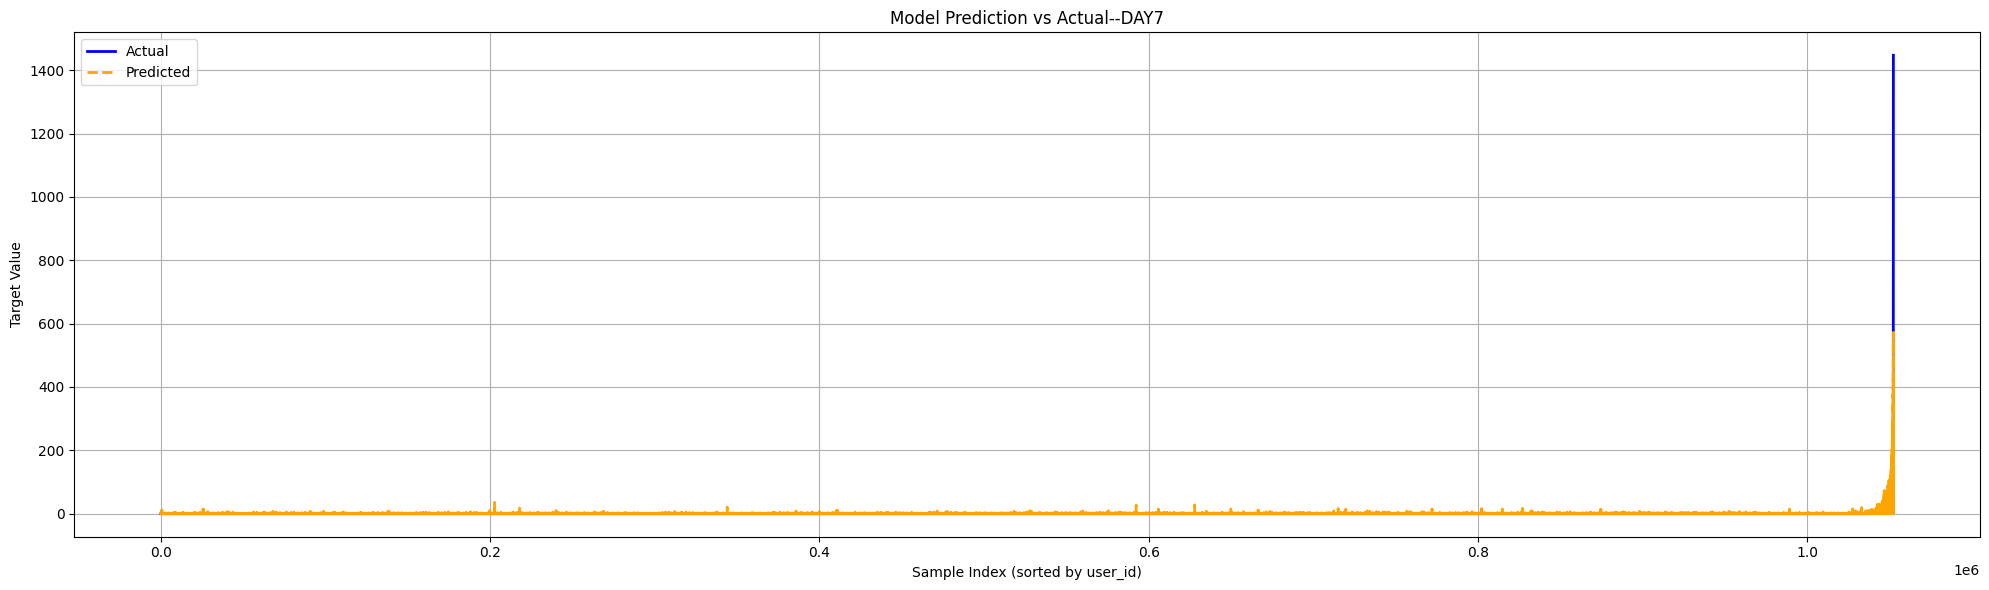

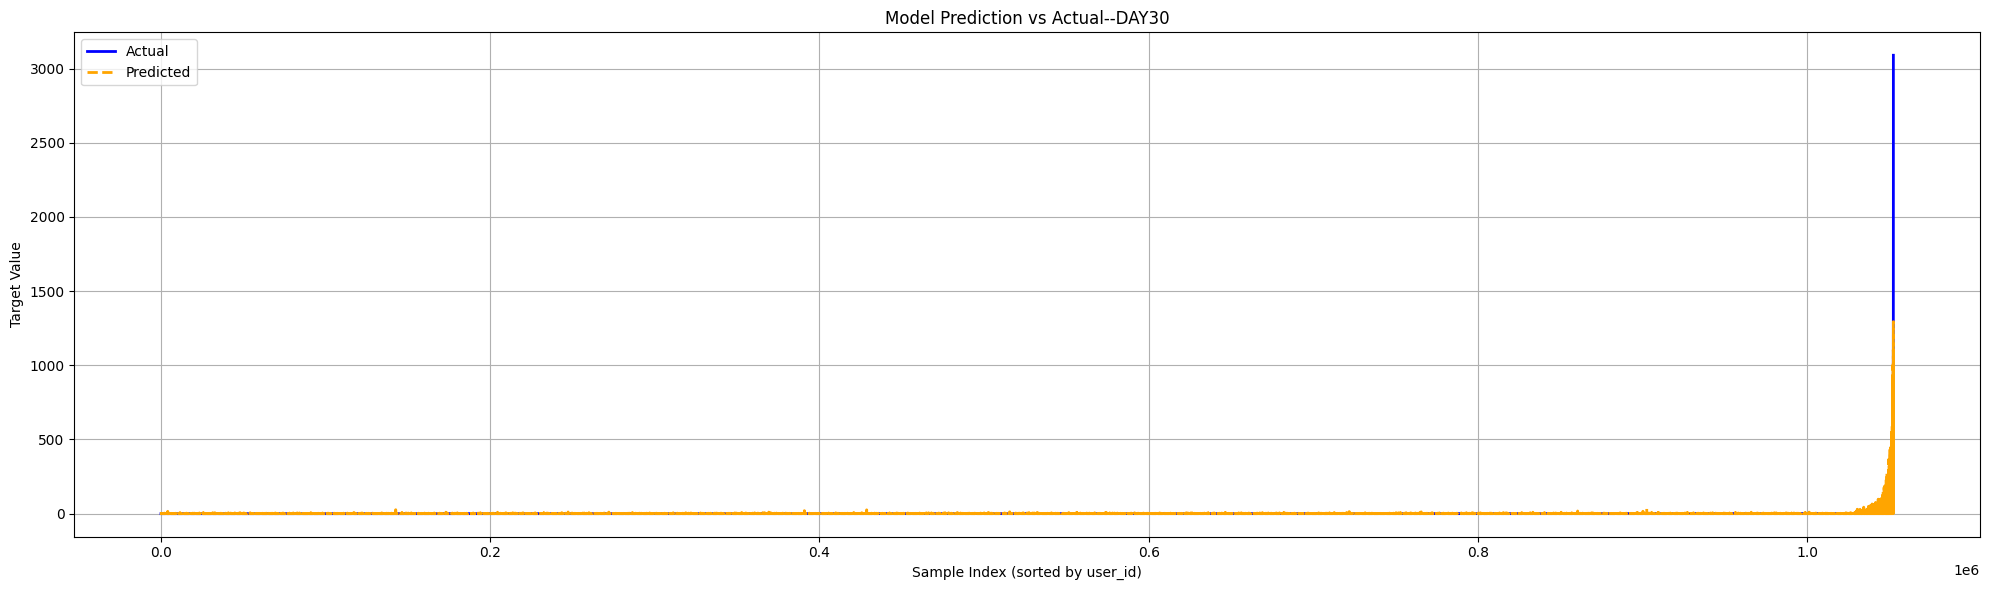

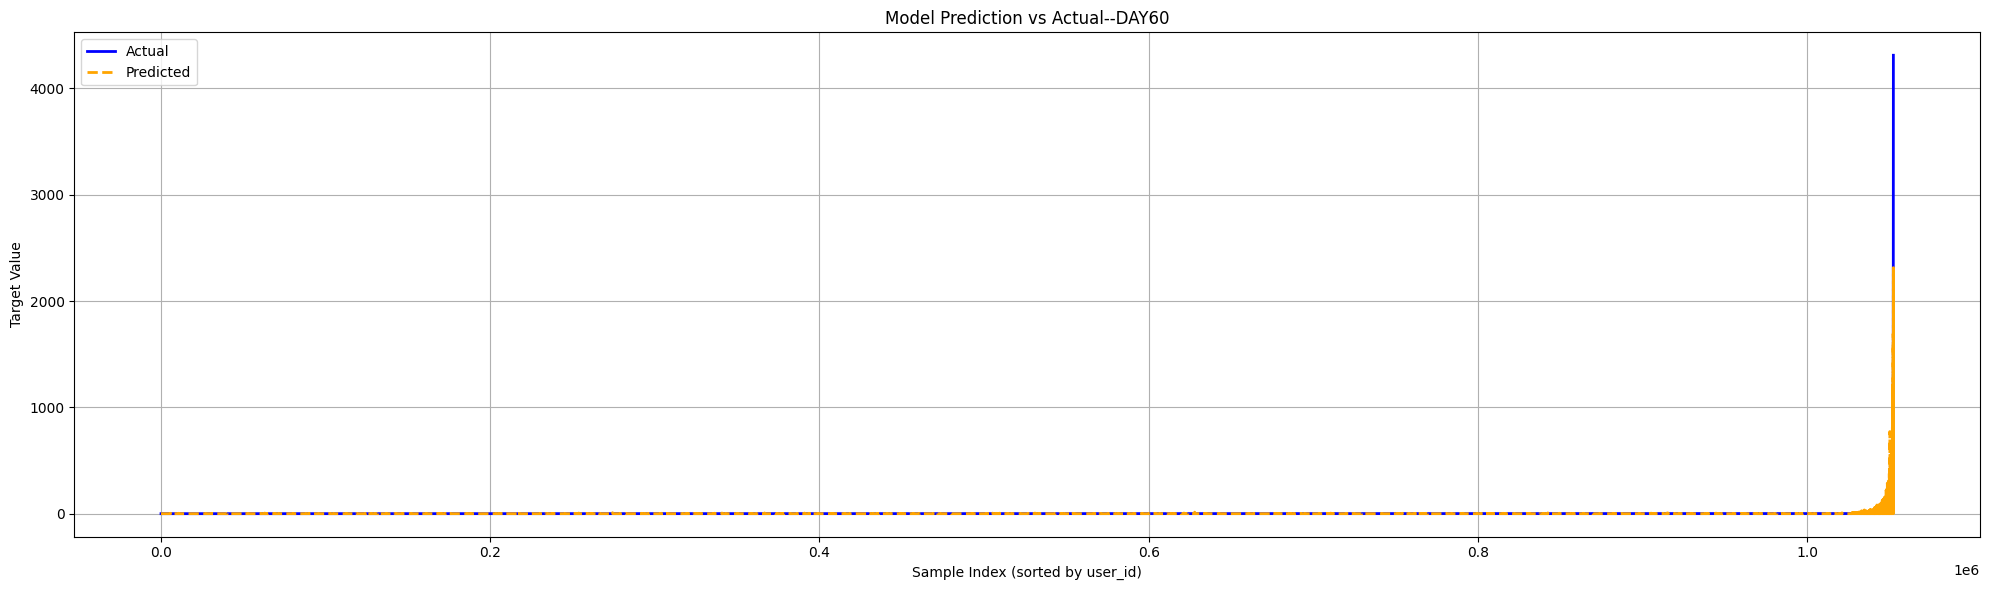

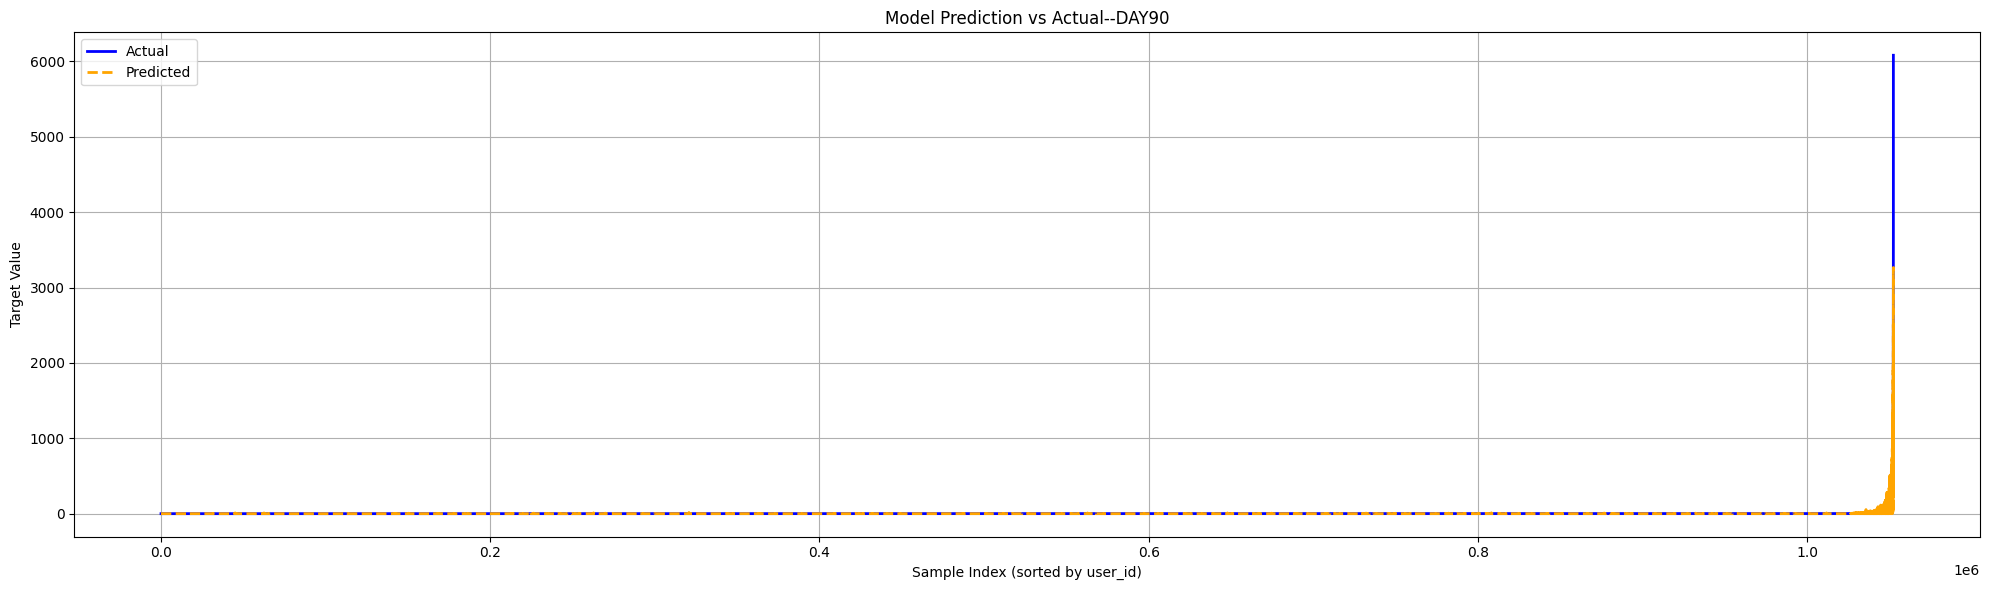

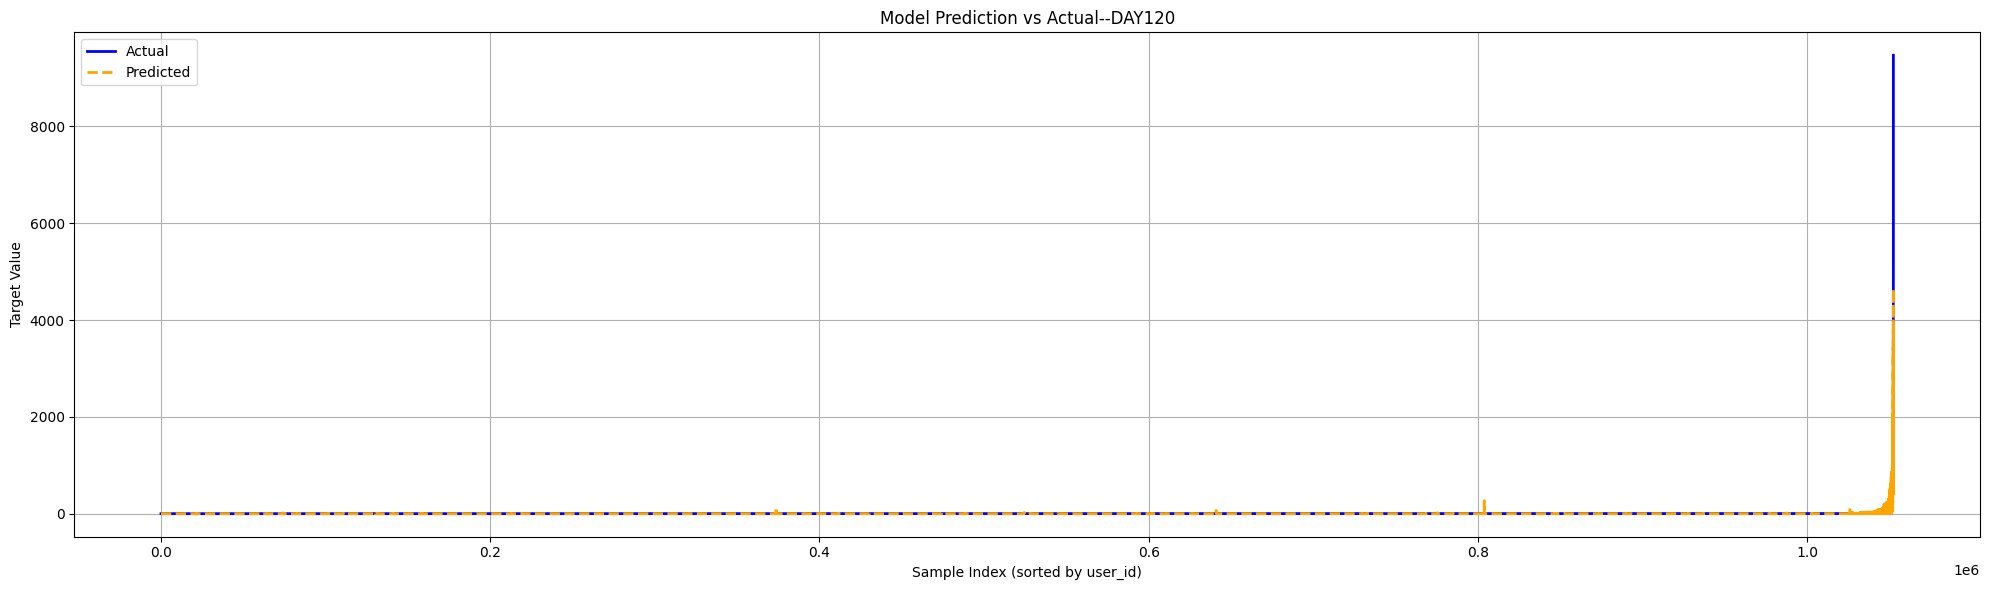

In [25]:
import matplotlib.pyplot as plt
# 目前存在的生命周期
# 可作为验证
day_valid = [7, 30, 60, 90, 120]
for day in day_valid:
    plt.figure(figsize=(20, 6))
    result_df_sorted = preds_results[day].sort_values(by="actual").reset_index(drop=True)
    plt.plot(result_df_sorted["actual"], label='Actual', color='blue', linewidth=2)
    plt.plot(result_df_sorted["pred"], label='Predicted', color='orange', linewidth=2, linestyle='--')
    
    plt.title(f"Model Prediction vs Actual--DAY{day}")
    plt.xlabel('Sample Index (sorted by user_id)')
    plt.ylabel('Target Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [26]:
# 其他模型评估方法

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score

def evaluate_ltv(y_true, y_pred):
    
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    msle = mean_squared_log_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MSLE: {msle:.4f}")
    print(f"R²: {r2:.4f}")

for day in day_valid:
    
    evaluate_ltv(preds_results[day]['actual'].values, preds_results[day]['pred'].values)


RMSE: 3.9803
MAE: 0.1980
MSLE: 0.0277
R²: 0.6717
RMSE: 12.0585
MAE: 0.6434
MSLE: 0.0542
R²: 0.5802
RMSE: 12.1499
MAE: 0.5284
MSLE: 0.0165
R²: 0.8185
RMSE: 13.3821
MAE: 0.4205
MSLE: 0.0072
R²: 0.8662
RMSE: 15.9692
MAE: 0.4225
MSLE: 0.0051
R²: 0.8619


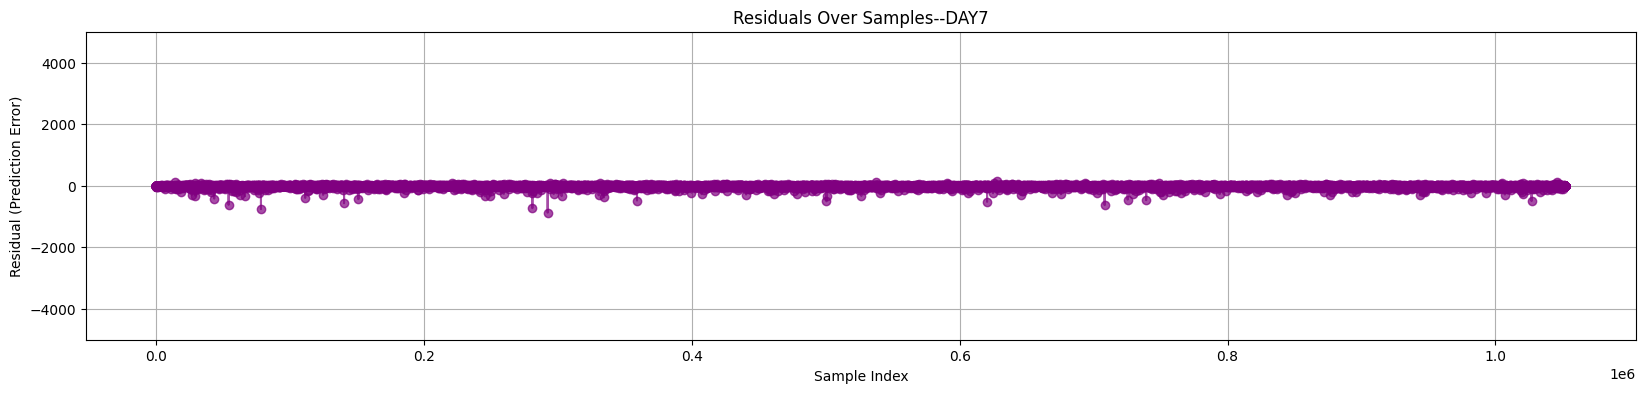

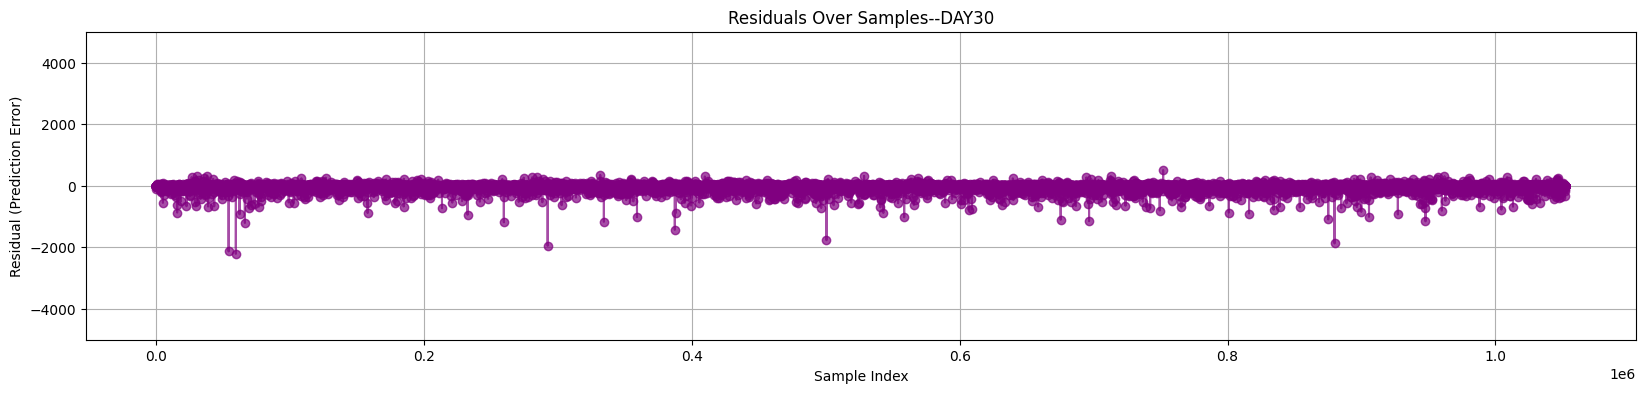

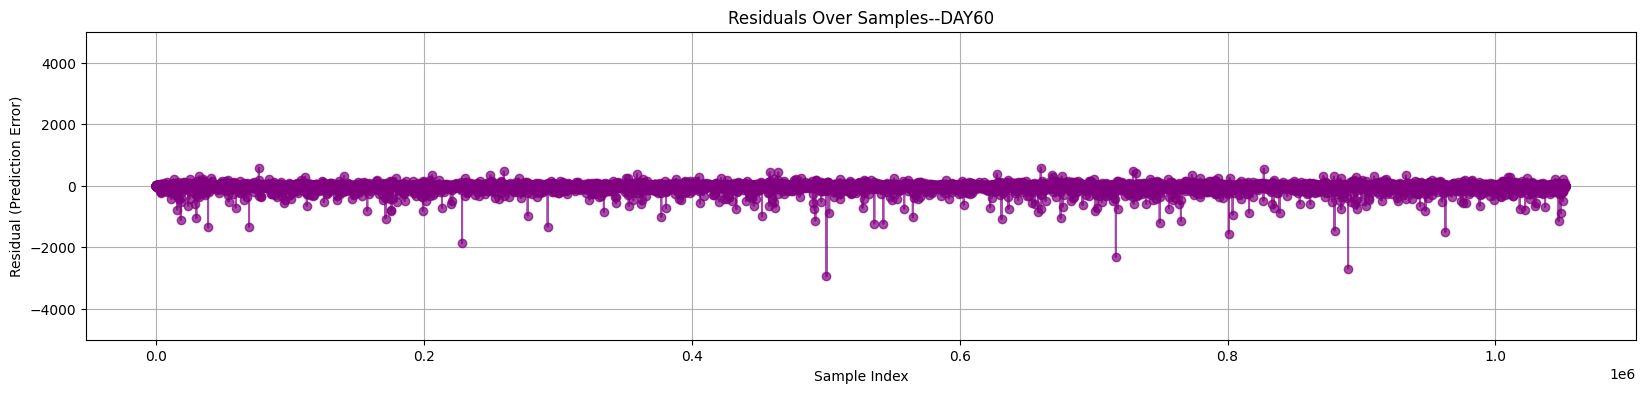

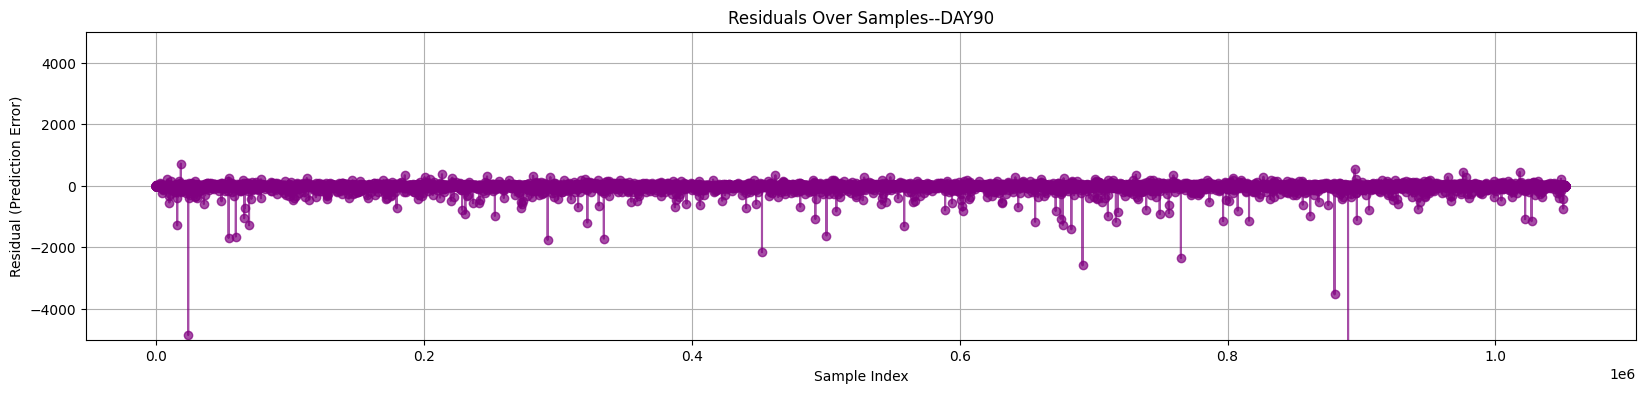

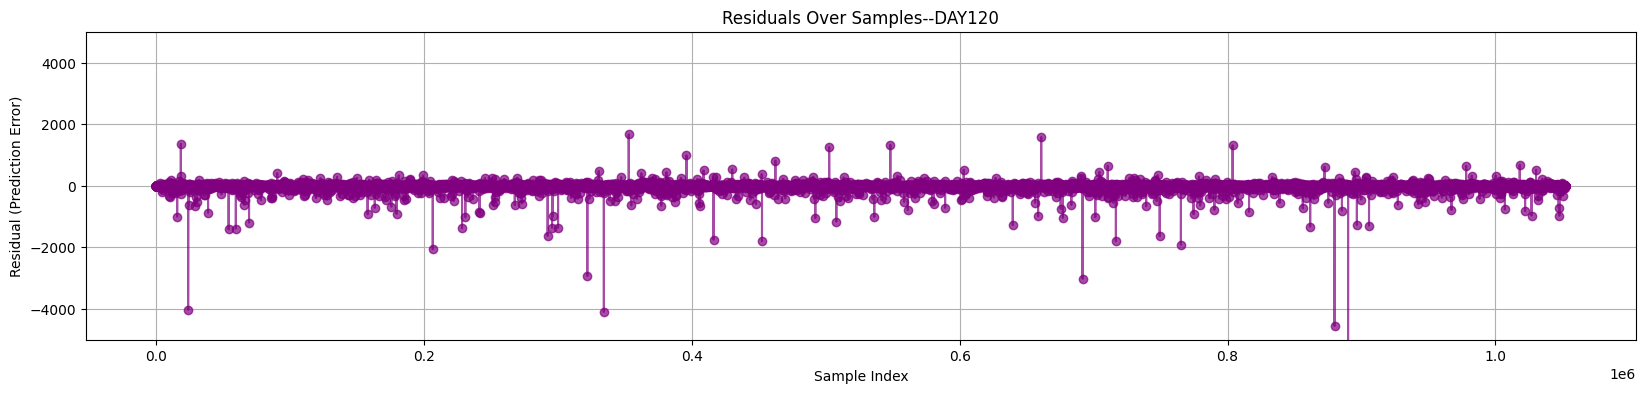

In [27]:
# 残差分析

import matplotlib.pyplot as plt

for day in day_valid:
    residuals = preds_results[day]["pred"].values - preds_results[day]["actual"].values
    plt.figure(figsize=(20, 4))
    plt.plot(residuals, marker='o', linestyle='-', color='purple', alpha=0.7)
    plt.title(f"Residuals Over Samples--DAY{day}")
    plt.xlabel('Sample Index')
    plt.ylim(-5000,5000)
    plt.ylabel('Residual (Prediction Error)')
    plt.grid(True)
    plt.show()


# 计算期群回收，需要固定期群的花费以及LTV 的总和
    以同一项目的历史注册玩家数据进行模型构建、训练和测试
    选取要预测的期群数据，给定改期群的花费，对上述的预测值进行求和，计算出固定周期的回收

In [28]:
# 需要给定该周期的总花费
# 以DA 2024.01月份的数据来预测DA 2024.08月份回收情况

for day in days_list:
    roas_pre = preds_results[day]["pred"].sum()/cost
    roas_act = preds_results[day]["actual"].sum()/cost

    print(f"Day{day}_ROAS的预测值：", f"{roas_pre:.2%}")
    print(f"Day{day}_ROAS的实际值：", f"{roas_act:.2%}")



Day7_ROAS的预测值： 8.93%
Day7_ROAS的实际值： 11.97%
Day30_ROAS的预测值： 22.50%
Day30_ROAS的实际值： 34.79%
Day60_ROAS的预测值： 44.81%
Day60_ROAS的实际值： 52.93%
Day90_ROAS的预测值： 58.84%
Day90_ROAS的实际值： 65.25%
Day120_ROAS的预测值： 68.53%
Day120_ROAS的实际值： 74.15%
Day240_ROAS的预测值： 84.28%
Day240_ROAS的实际值： 87.02%
Day300_ROAS的预测值： 83.14%
Day300_ROAS的实际值： 87.02%


In [ ]:
for day in days_list:
    roas_pre = preds_results[day]["pred"].mean()
    roas_act = preds_results[day]["actual"].mean()

    print(f"Day{day}_LTV的预测值：", f"{roas_pre:.2%}")
    print(f"Day{day}_LTV的实际值：", f"{roas_act:.2%}")


# 真实预测，没有y_actual参考

In [ ]:
def predict_data(X1, X2, model1, model2):
    '''
        分类模型预测
        提取有付费希望的群体
        回归模型预测LTV
    '''
    existing_payer_tag = [col for col in payer_tag if col in X1.columns]
    if not existing_payer_tag:
        raise ValueError("❌ X中不包含任何payer_tag列，无法识别未付费用户。")
    # print(eval(f"X_test_day{day}_1").drop(columns=existing_payer_tag).head())

    temp = model1.predict(X1.drop(columns=existing_payer_tag), num_iteration=model1.best_iteration)
    
    # 建立副本 deep copy
    X1_copy = X1.copy()
    X1_copy['pay_class_pred'] = (temp > 0.5).astype(int)
   
    # 筛选数据
    mask_payfu = (X1_copy['pay_class_pred']==1)
    X_combined = pd.concat(
        [X1_copy[mask_payfu].drop(columns='pay_class_pred'), X2], axis = 0)
    y_combined = pd.concat(
        [y1[mask_payfu], y2], axis = 0)

    preds_log = model2.predict(X_combined, num_iteration=model2.best_iteration)
    preds = pd.Series(np.expm1(preds_log)).clip(lower=0).values
    
    X_combined['pred'] = preds
    # print(eval(f"X_combined_test_day{day}").head())

    # 添加上一步被判断为后续不会付费玩家的信息
    X1_copy.loc[~mask_payfu, 'pred'] = 0
    # print(y1[~mask_payfu].values)
    # print(X1_copy[~mask_payfu][['actual', 'pred']].head())

    temp = pd.concat([X_combined, X1_copy[~mask_payfu].drop(columns='pay_class_pred')], axis = 0)

    pred_results = pd.concat([id_test.rename('uid'), temp], axis = 1)

    return pred_results